# Stage modelling from spatial features

In [2]:
import os
import numpy as np
import anndata as ad
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
import scanpy as sc
from joblib import Parallel, delayed
import warnings, logging

import shap

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Overall cell features

In [3]:
cell_table = pd.read_csv("../../data/cell_table_with_types_stage.csv", 
                         index_col = 0)

/tmp/ipykernel_204878/1000358550.py:1: DtypeWarning: Columns (39,40,41,42,43,44,45,46,48,49,52,53,54,55,56,57,58,59,60,61,62,63,65,66,68) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
metab_markers = ['CA9', 'CD98', 'CytC', 'MCT1', 'ASCT2', 'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'ARG1', 'CPT1A', 'Ki67']

# Only metabolic markers for cancer/epithelial cells
df = cell_table.loc[cell_table.consensus == "Cancer_cell",metab_markers] 
meta = cell_table.loc[cell_table.consensus == "Cancer_cell",["Stage","fov"]]

# A few FOVs show only few epithelial cells and might only add noise to the analysis
sparse_epi_fovs = meta.fov.value_counts()[meta.fov.value_counts() <= 20].index
df = df.loc[~meta.fov.isin(sparse_epi_fovs)]
meta = meta.loc[~meta.fov.isin(sparse_epi_fovs)]

# Only keep well-annotated cancer stages
epithelial_subset = meta["Stage"].isin(["pT1", "pT2", "pT3", "pT4"]).values

We choose to perform the prediction task on well annotated FOVs with sufficient epithelial cells.
```python
# Note: 13 FOVs are not annotated as healthy or to a specific cancer stage
cell_table.loc[cell_table.fov.isin(meta.loc[~epithelial_subset].fov), "fov"].unique()

# Additionally, 7 FOVs do not contain epithelial cells and are therefore lost
set(cell_table.fov) - set(meta.fov)

# Finally, we also exclude 27 FOVs that contain only few epithelial cells
# The rationale is to compare on the cellular organization around the colorectal epithelium
set(sparse_epi_fovs)
```

In [5]:
# The least represented conditions are mostly unaffected
print(cell_table.groupby("fov").first().Stage.value_counts())
print(meta.loc[epithelial_subset].groupby("fov").first().Stage.value_counts())

Stage
pT3          234
pT4          105
pT2           92
pT1           19
SCT            6
Colon-no.      5
Name: count, dtype: int64
Stage
pT3    218
pT4     97
pT2     85
pT1     18
Name: count, dtype: int64


## Prepare cross-validation

In [6]:
# Define which fovs will be held out for validation (outer loop)
fov_stage_table = meta.loc[epithelial_subset].drop_duplicates().reset_index(drop=True)
fov_inner, fov_val, y_inner, y_val = train_test_split(
    fov_stage_table["fov"], fov_stage_table["Stage"], test_size=0.2, random_state=0, stratify=fov_stage_table["Stage"])
meta["inner"] = meta["fov"].isin(fov_inner)
# For sanity check, the following should consistently be used as validation set
" ".join(fov_val.sort_values())

'A1a A1f A1h A2g A2i A2q A2r A3m A4e A4n A5a A5q A6b A6c A6g A6m A6p A6q A6r A7f A7p A8a A8m A9o A9q B1h B1k B2a B2b B2k B2o B3c B3g B4b B4g B4m B6i B6q B7c B7p B7r B8b B8d B8g B8i B8l B9c B9d B9h B9m B9n B9o C1i C1l C2a C2f C2k C3c C3h C4a C4g C4k C5a C5k C5l C6d C8a C8h D1i D1l D1m D2e D2k D4c D5b D5d D5h D5k D5l D6c D6k D7a D8d D8h'

In [7]:
n_splits = 4

cv_folds = StratifiedGroupKFold(n_splits=n_splits)
for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                  meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                  groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
    # All stages should be present in both train and test
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov")["Stage"].first().unique()) == 4
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov")["Stage"].first().unique()) == 4
    # Print the first test FOVs
    print(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index[:5]) 

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


We can split the data at the cell level to allow applications that involve processing single cells. The grouping ensures that the data is split per FOV without contamination (i.e. cells from a given FOV present both in training and testing).

In [8]:
meta
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

In [9]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov").mean()
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

Alternatively, we directly split the FOVs, for applications that involve FOV-level features. 
Note: we could generate independent folds, but the FOV distribution would not be identical.
We choose to directly define the folds to be the same to make results more comparable.
```Python
cv_folds_fov = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)
for train, test in cv_folds_fov.split(df_per_fov.loc[meta_per_fov["inner"]],
                                      meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
                                    ):
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 5
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 5
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5]) 

```

In [10]:
def conv_traintest_cells_to_fov():
    for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                    meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
        test_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index
        train_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov").first().index
        test_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(test_fovs))[0]
        train_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(train_fovs))[0]
        yield (train_fovs_ind, test_fovs_ind)

# Should work as the output of `split` method: two arrays of indices
cv_folds_fov = [x for x in conv_traintest_cells_to_fov()]

for train, test in cv_folds_fov:
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 4
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 4
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5])

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


## Model 0: Baseline (most abundant label)

In [11]:
np.mean([f1_score(LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]),
                [2 for _ in range(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].shape[0])],
                average="macro")
                for train, test in cv_folds_fov])

0.17126558017457122

In [12]:
for train, test in cv_folds_fov:
    y_train = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
    y_test = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
    
    le = LabelEncoder()
    baseline_f1_scores = [f1_score(
                            le.fit_transform(y_test),
                            np.random.randint(0,5,y_test.shape[0]),
                            average="macro")
                        for _ in range(1000)]
    print(f"Baseline: {np.median(baseline_f1_scores)} (95% CI: {np.percentile(baseline_f1_scores, 2.5)}-{np.percentile(baseline_f1_scores, 97.5)})")
baseline_f1 = np.median(baseline_f1_scores)

Baseline: 0.1507389043728666 (95% CI: 0.08774730948275586-0.22289636111367414)
Baseline: 0.15368703976950138 (95% CI: 0.08910535985906749-0.2251345643544078)
Baseline: 0.1545514647023178 (95% CI: 0.0896717130664499-0.22591457626269584)
Baseline: 0.15322237193204935 (95% CI: 0.08642367511520738-0.22545934514963828)


In [13]:
np.random.seed(0)
all_f1_scores = []
for train, test in cv_folds_fov:
    y_train = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
    y_test = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
    
    le = LabelEncoder()
    baseline_f1_scores = [f1_score(
                            le.fit_transform(y_test),
                            le.transform(np.random.choice(y_train, len(y_test), replace=True)),
                            average="macro")
                        for _ in range(1000)]
    print(f"Baseline: {np.median(baseline_f1_scores)} (95% CI: {np.percentile(baseline_f1_scores, 2.5)}-{np.percentile(baseline_f1_scores, 97.5)})")
    all_f1_scores.append(baseline_f1_scores)
# Expectation of performance across all folds
all_f1_scores = np.array(all_f1_scores)
print(f"Baseline: {np.median(np.median(all_f1_scores, axis=0))} (95% CI: {np.mean(np.percentile(all_f1_scores, 2.5, axis=0))}-{np.mean(np.percentile(all_f1_scores, 97.5, axis=0))})")
baseline_f1 = np.median(all_f1_scores)

Baseline: 0.24373377399740384 (95% CI: 0.16763731365293866-0.35463332634318406)
Baseline: 0.244611038133318 (95% CI: 0.16527132740447958-0.3361897730545976)
Baseline: 0.2427863219637999 (95% CI: 0.1708228348669525-0.3521886051884862)
Baseline: 0.24461319016703584 (95% CI: 0.16653414312799256-0.35216117385458157)
Baseline: 0.24477415871808744 (95% CI: 0.20491236573613264-0.29433320577147765)


## Model 1: Cell type composition

In [14]:
cell_table.groupby("fov")["consensus"].value_counts().unstack().fillna(0).drop(columns=["Unclear"])

consensus,APC,B_cell,CAF,CD163_Macrophage,CD4_Tcell,CD68_Macrophage,CD8_Tcell,Cancer_cell,Endothelial_cell,Monocyte,NK_cell,Neutrophil,Other_immune_cell,T_reg_cell
fov,,,,,,,,,,,,,,
A1a,0.0,0.0,11.0,0.0,7.0,4.0,2.0,1288.0,23.0,3.0,7.0,3.0,22.0,0.0
A1c,0.0,0.0,65.0,15.0,3.0,27.0,3.0,1145.0,19.0,40.0,16.0,62.0,9.0,0.0
A1d,7.0,0.0,69.0,5.0,4.0,11.0,3.0,693.0,66.0,32.0,3.0,51.0,11.0,0.0
A1e,11.0,0.0,88.0,10.0,23.0,6.0,33.0,1182.0,59.0,8.0,10.0,14.0,27.0,1.0
A1f,3.0,0.0,14.0,3.0,34.0,2.0,5.0,854.0,22.0,53.0,9.0,38.0,7.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E3c,9.0,248.0,61.0,12.0,346.0,28.0,57.0,251.0,54.0,45.0,11.0,1.0,61.0,20.0
E3e,2.0,0.0,11.0,0.0,102.0,19.0,30.0,213.0,25.0,62.0,1.0,0.0,38.0,1.0
E4a,14.0,27.0,46.0,10.0,95.0,26.0,20.0,317.0,53.0,76.0,6.0,0.0,59.0,2.0


In [15]:
cell_type_proportions = cell_table.groupby("fov")["consensus"].value_counts().unstack().fillna(0) # .drop(columns=["Unclear"])
# Normalize by the number of cells in each FOV
cell_type_proportions = cell_type_proportions.div(cell_type_proportions.sum(axis=1), axis=0)
# Match to metadata and kept FOVs
cell_type_proportions = cell_type_proportions.loc[meta_per_fov.index]

We could give more weight to rarer classes, but in practice this did not improve performance on inner folds nor reduce overfitting across models.
```python
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"])
)
scores = cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    cell_type_proportions.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    # params={'sample_weight':sample_weights},
    scoring='f1_macro')
np.mean(scores)
# And later in direct model training
xgb.fit(train_composition,
        LabelEncoder().fit_transform(train_meta),
        # sample_weight=sample_weights[train]
        )
```

In [16]:
scores = cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    cell_type_proportions.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')
np.mean(scores)

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:06:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



0.2703869209035381

For cell type composition, XGBoost seems appropriate (good performance, and in practice a bit more stable than RF, although slower).
```Python
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Define models and their hyperparameters
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression()
}

params = {
    'RandomForest': {
        'n_estimators': [20, 50, 100, 200, 300],
        'max_depth': [2, 3, 5]
    },
    'XGBoost': {
        'n_estimators': [20, 50, 100, 200, 300],
        'max_depth': [2, 3, 5],
        'device': ['cuda'],
        'random_state': [0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs']
    }
}

# Perform GridSearchCV for each model
best_models = {}
best_scores = {}
for model_name in models:
    grid_search = GridSearchCV(models[model_name], params[model_name], cv=cv_folds_fov, scoring='f1_macro')
    grid_search.fit(cell_type_proportions.loc[meta_per_fov["inner"]], 
                    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
                    sample_weight=sample_weights)
    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_

# Print the best models and their parameters
for model in best_models.keys():
    print(model, best_models[model])
    print("Best score:", best_scores[model])
```

In [17]:
def process_fold_composition(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_composition = cell_type_proportions.loc[meta_per_fov["inner"]].iloc[train]
        test_composition = cell_type_proportions.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_composition,
                LabelEncoder().fit_transform(train_meta),
                )

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_composition)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [18]:
def test_estimator_composition(estimators, depth=4):
    scores = [process_fold_composition(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model1_cell_composition_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [21]:
# Parallelize the hyperparameter loop | ~81mn
np.random.seed(0)
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_composition)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

15 3 0.239178730626099
45 3 0.22963840819833087
25 3 0.24428068685952078
35 3 0.23692455665533524
55 3 0.2373180269400874
75 3 0.24117412124740087
65 3 0.24223485973485973
85 3 0.24058003722317345
95 3 0.24675509881294086
105 3 0.24181493644228994
115 3 0.25780794086335895
125 3 0.2638841940877376
135 3 0.25421302565901216
145 3 0.251429005074034
155 3 0.2587446559799355
165 3 0.256050875515199
175 3 0.2537305237789982
185 3 0.25137135782346365
195 3 0.2516402227756537
205 3 0.26536500536500535
215 3 0.26536500536500535
225 3 0.2594056108907594
235 3 0.2647183537035022
245 3 0.2622486772486773
255 3 0.25693593443593443
15 5 0.23889793650961183
265 3 0.25693593443593443
275 3 0.254016879016879
25 5 0.23928079529797913
285 3 0.254016879016879
295 3 0.25652205902205905
35 5 0.2416988566988567
45 5 0.2460708770905515
305 3 0.25652205902205905
315 3 0.2536622733991155
55 5 0.2534564419621801
65 5 0.24515449454635654
325 3 0.2536622733991155
75 5 0.24146325702164936
345 3 0.2536622733991155


[0.239178730626099,
 0.24428068685952078,
 0.23692455665533524,
 0.22963840819833087,
 0.2373180269400874,
 0.24223485973485973,
 0.24117412124740087,
 0.24058003722317345,
 0.24675509881294086,
 0.24181493644228994,
 0.25780794086335895,
 0.2638841940877376,
 0.25421302565901216,
 0.251429005074034,
 0.2587446559799355,
 0.256050875515199,
 0.2537305237789982,
 0.25137135782346365,
 0.2516402227756537,
 0.26536500536500535,
 0.26536500536500535,
 0.2594056108907594,
 0.2647183537035022,
 0.2622486772486773,
 0.25693593443593443,
 0.25693593443593443,
 0.254016879016879,
 0.254016879016879,
 0.25652205902205905,
 0.25652205902205905,
 0.2536622733991155,
 0.2536622733991155,
 0.2511205030002022,
 0.2536622733991155,
 0.2511205030002022,
 0.2511205030002022,
 0.2511205030002022,
 0.24560440635670416,
 0.25070940735936725,
 0.251005962378561,
 0.25070940735936725,
 0.25070940735936725,
 0.25070940735936725,
 0.24500795630077335,
 0.2448561701024755,
 0.2476978355381259,
 0.24475402505651

In [19]:
pd.read_csv("../../data/model1_cell_composition_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
227,15,5,0.295036
25,15,5,0.295036
162,455,7,0.294420
167,485,7,0.294420
170,495,7,0.294420
171,505,7,0.294420
364,455,7,0.294420
305,145,7,0.290464
103,145,7,0.290464
316,195,7,0.289334


In [20]:
# Table used to score inner fold scores for all models
all_models_inner = pd.DataFrame(columns=["model", "score"])
# Compute scores for this model
scores = [process_fold_composition(train, test, n_estimators=15, n_depth=5)
              for train, test in cv_folds_fov]

print(np.median(scores))
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M1 composition" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

0.2950358422939068


/tmp/ipykernel_204878/1934415969.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


### SHAP analysis

[[ 14   0   0   0]
 [  0  68   0   0]
 [  0   0 174   0]
 [  0   0   0  78]]


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig2/compo_importance_correctly_predicted_samples.pdf


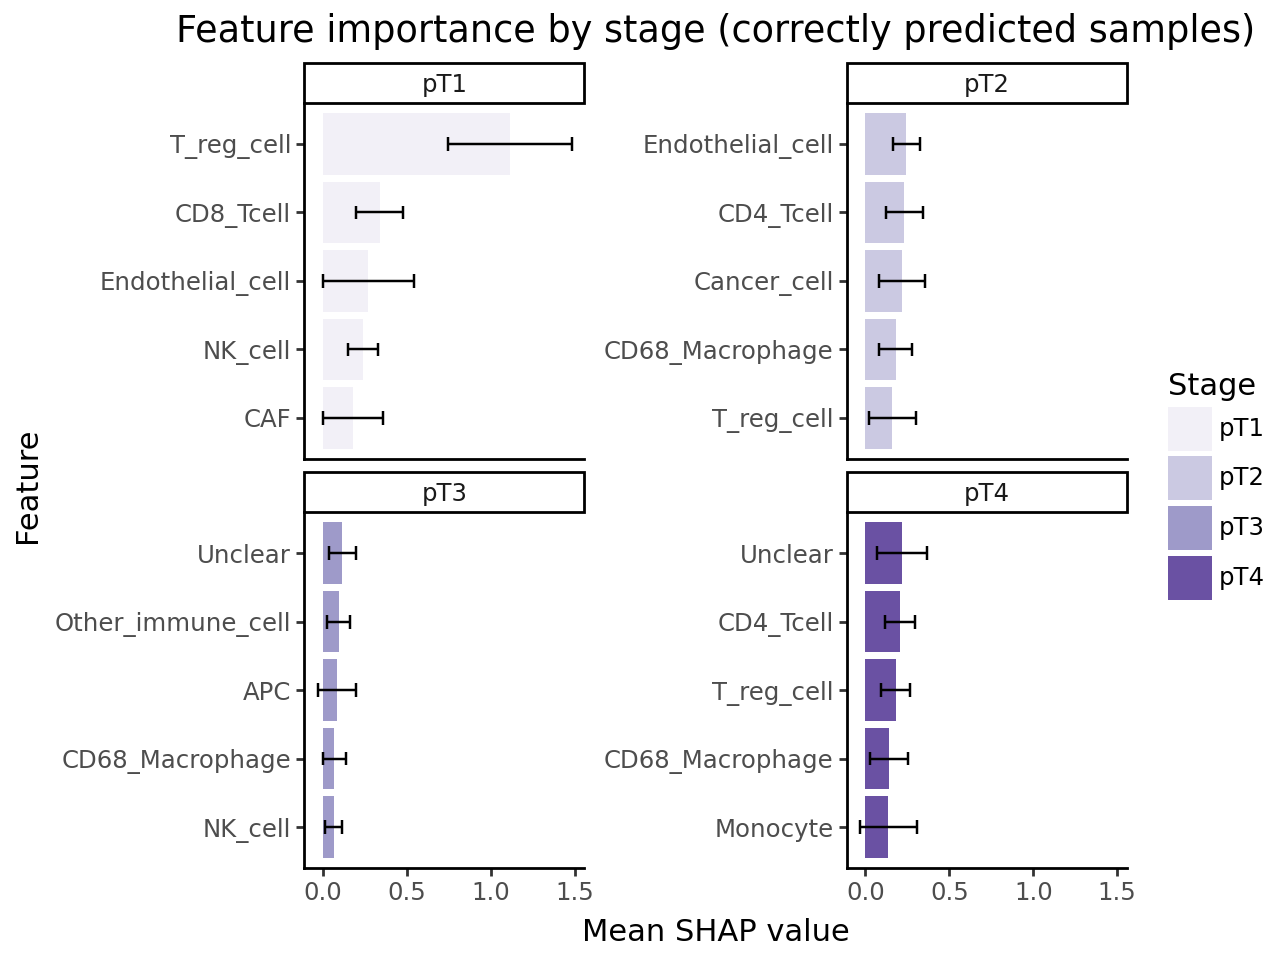

In [21]:
FT_PER_CLASS = 5 # Number of most important features kept per class

train_fov = cell_type_proportions.loc[meta_per_fov["inner"]]
original_stages = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(original_stages)

xgb = XGBClassifier(
    n_estimators=15, 
    max_depth=5, 
    device="cuda", 
    random_state=0)
xgb.fit(train_fov,
        true_labels)

explainer = shap.Explainer(xgb)
shap_values = explainer(train_fov)

# Purples
pal_stages = [(242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

predicted_labels = xgb.predict(train_fov)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Few errors on training set, so not meaningful to interpret misclassified FOVs

# For each stage, see how the true positive samples were predicted (SHAP values)

# Get indices of correctly predicted samples for each class
correct_indices = {class_idx: np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0] 
                   for class_idx in range(conf_matrix.shape[0])}

shap_values_list = []
for class_idx, indices in correct_indices.items():
    shap_values_class = pd.DataFrame(shap_values.values[indices, :, class_idx], 
                                     columns=train_fov.columns)
    shap_values_class['fov'] = train_fov.index[indices]
    shap_values_class['class'] = label_encoder.inverse_transform([class_idx])[0]  # Use original stage names
    shap_values_list.append(shap_values_class)

shap_values_df = pd.concat(shap_values_list)

# Melt the DataFrame for easier plotting with plotnine
shap_values_melted = shap_values_df.melt(id_vars=['fov', 'class'], 
                                        var_name='Feature', 
                                        value_name='SHAP Value')

# Calculate mean and std SHAP values per feature per class
feature_importance = shap_values_melted.groupby(['class', 'Feature'])['SHAP Value'].agg(['mean', 'std']).reset_index()
feature_importance["abs_mean"] = np.abs(feature_importance["mean"])

# Create composite ordered categories per class
composite_data = []
categories_all = []
for class_name, group in feature_importance.groupby('class'):
    # Get top features for this class
    top_features = group.nlargest(FT_PER_CLASS, 'abs_mean').copy()
    # Sort by actual mean value (not absolute) for display order
    top_features = top_features.sort_values('mean', ascending=True)
    # Create composite category
    top_features['Class_Feature'] = top_features['class'] + ":" + top_features['Feature']
    categories_all.extend(top_features['Class_Feature'].tolist())
    composite_data.append(top_features)

# Combine data and assign global ordered categorical
feature_importance = pd.concat(composite_data)
feature_importance['Class_Feature'] = pd.Categorical(
    feature_importance['Class_Feature'],
    categories=categories_all,
    ordered=True
)

# Create plot
gp = (ggplot(feature_importance, 
        aes(x='Class_Feature', y='mean', fill='class'))
    + geom_bar(stat='identity')
    + geom_errorbar(aes(ymin='mean-0.5*std', ymax='mean+0.5*std'), 
                    width=0.2)
    + coord_flip()
    + theme_classic()
    + scale_fill_manual(values=pal_stages)
    + scale_x_discrete(labels=dict(zip(feature_importance['Class_Feature'], 
                                     feature_importance['Feature'])))
    + labs(title='Feature importance by stage (correctly predicted samples)', 
           x='Feature', y='Mean SHAP value', fill='Stage')
    + facet_wrap('~class', scales='free_y', ncol=2)
)

ggsave(gp, "../../figures/fig2/compo_importance_correctly_predicted_samples.pdf", width=7, height=5)

gp.show()


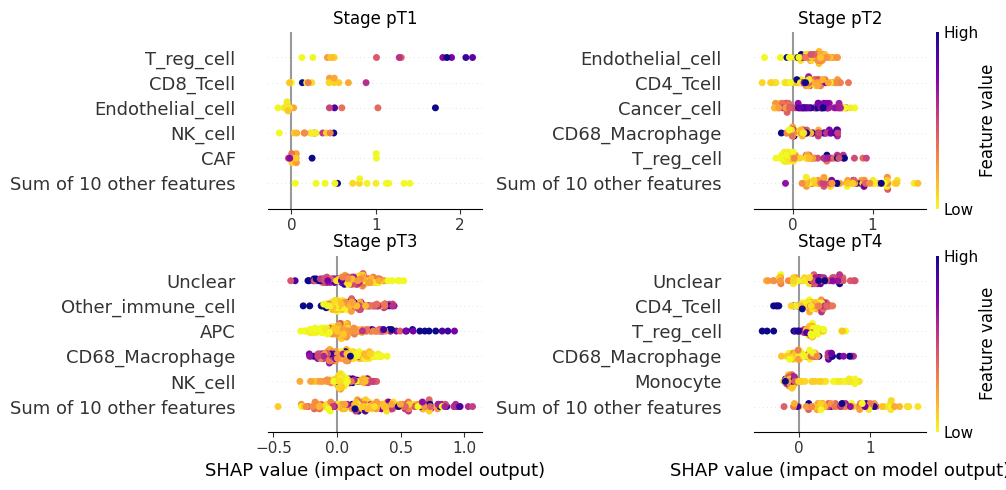

In [22]:
# Create a figure with 2x2 subplots with more space between them
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through classes and create SHAP beeswarm plot for each
for class_idx in range(shap_values.shape[2]):
    row = class_idx // 2
    col = class_idx % 2
    plt.sca(axes[row, col])
    
    # Get SHAP values for correctly predicted samples of this class
    class_shap = shap_values[np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0],:,class_idx]

    # Calculate average absolute SHAP values for ordering
    mean_abs_shap = np.abs(class_shap.values.mean(0))
    feature_order = np.argsort(-mean_abs_shap)  # Descending order
    
    # Create beeswarm plot with conditional show_colorbar
    shap.plots.beeswarm(
        class_shap, 
        show=False, 
        color=plt.get_cmap("plasma_r"),
        max_display=FT_PER_CLASS + 1,
        s = 25,
        order=feature_order,
        color_bar=col == 1  # Only show colorbar for right column
    )
    
    plt.title(f'Stage {label_encoder.inverse_transform([class_idx])[0]}')
    
    # Remove x-axis label for top row
    if row == 0:
        plt.xlabel('')

# Increase figure size and adjust margins
plt.gcf().set_size_inches(10, 5)
plt.tight_layout(w_pad=1.0, h_pad=0.0)  # Increase spacing between subplots

# Save complete figure
plt.savefig("../../figures/fig2/compo_shap_vs_val_correctly_predicted_samples.pdf", 
            bbox_inches='tight')
plt.show()
plt.close()

## Model 2: Metabolic intensities
See *MetabViz.ipynb* for details.

In [23]:
pd.read_csv("../../data/model2_metab_markers_f1_scores.txt", names = ["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
0,15,3,0.287336
33,305,3,0.275632
24,255,3,0.274708
26,265,3,0.272072
21,225,3,0.271949
20,215,3,0.271949
16,175,3,0.271719
22,235,3,0.271641
37,325,3,0.270650
35,315,3,0.270650


In [24]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov")
df_per_fov = df_per_fov.mean().join(df_per_fov.std(), rsuffix="_std")

In [25]:
def process_fold_intensities(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_func = df_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_func = df_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_func,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_func)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [26]:
scores = [process_fold_intensities(train, test, n_estimators=15, n_depth=3)
              for train, test in cv_folds_fov]
print(np.median(scores))

0.2873355500237963


In [27]:
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M2 metabolic markers" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

## Model 3: Functional features

In [28]:
func_features = ["STING1", "Ki67", "MSH2", "MSH6", "PDL1"]

# We start by looking at the cell shape of cancer cells
df_func = cell_table.loc[cell_table.consensus == "Cancer_cell",func_features] 
# df_morpho.index = df_morpho.index.astype(str)
df_func = df_func.loc[meta.index].loc[epithelial_subset]
df_func["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean and std
df_func_per_fov = df_func.groupby("fov").mean().join(df_func.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_func_per_fov.index)

In [29]:
cross_val_score(
    XGBClassifier(
        n_estimators=100, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df_func_per_fov.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

array([0.28074773, 0.25196327, 0.19044248, 0.26632035])

In [30]:
def process_fold_func(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_func = df_func_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_func = df_func_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_func,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_func)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [31]:
def test_estimator_func(estimators, depth):
    scores = [process_fold_func(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model6_functional_markers_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [ ]:
# Parallelize the hyperparameter loop | ~ 30mn
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=16)(delayed(test_estimator_func)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()));

In [32]:
pd.read_csv("../../data/model6_functional_markers_f1_scores.txt", 
            header=None, 
            names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
13,145,3,0.275665
18,195,3,0.274030
17,185,3,0.273698
16,175,3,0.270785
21,225,3,0.269487
19,205,3,0.269220
20,215,3,0.269220
15,165,3,0.268452
3,45,3,0.267406
12,135,3,0.266458


In [33]:
scores = [process_fold_func(train, test, n_estimators=145, n_depth=3)
              for train, test in cv_folds_fov]
print(np.median(scores))
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M3 functional markers" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

0.2756645751595329


## Model 4: Morphological features

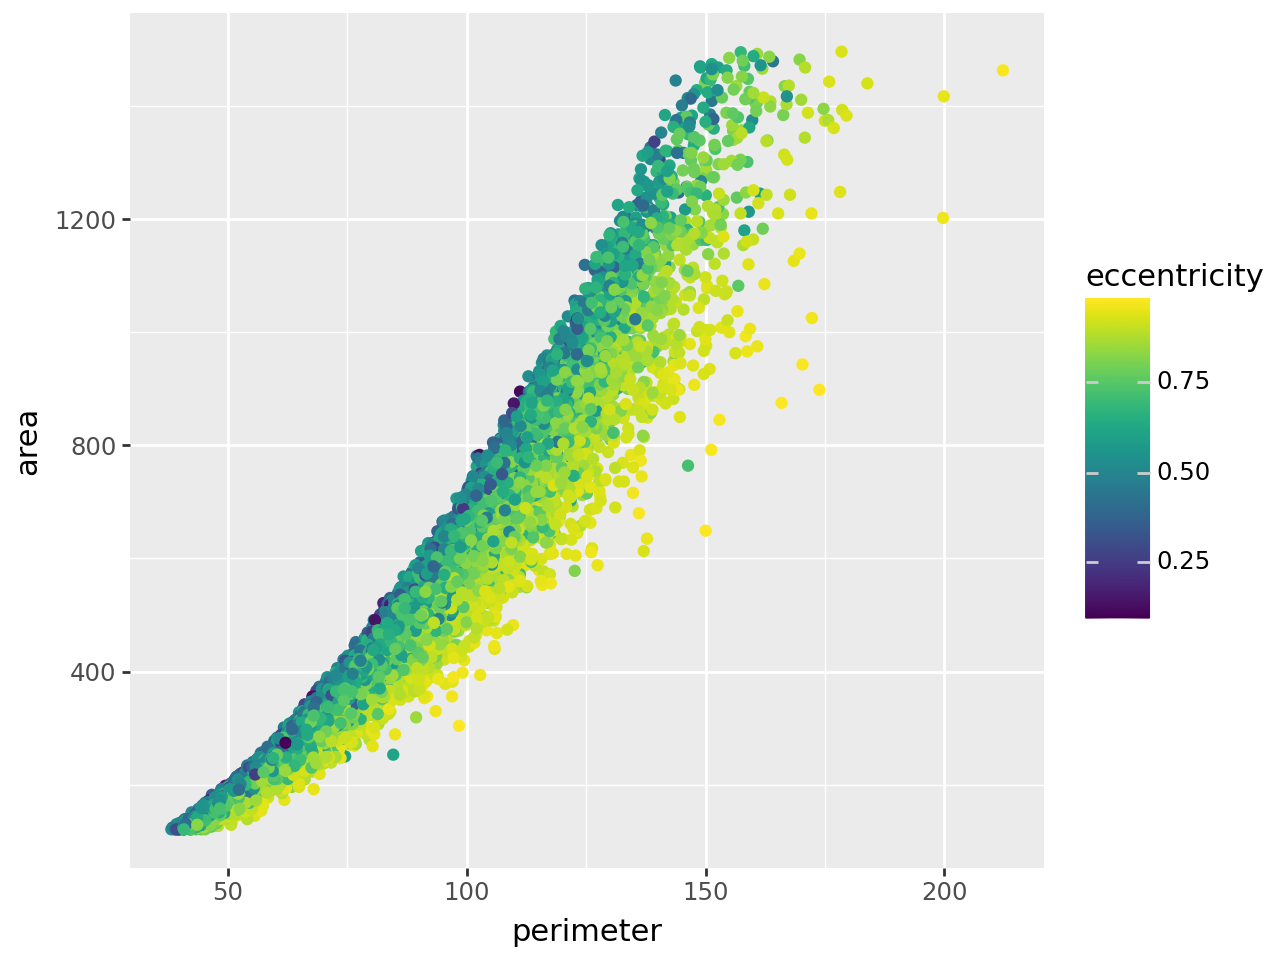

In [34]:
# Information appears correlated but complementary
ggplot(cell_table.sample(20000), aes(x = 'perimeter', y = 'area', color = 'eccentricity')) + geom_point()

In [35]:
morpho_features = ['eccentricity', 'perimeter', 'area']

# We start by looking at the cell shape of cancer cells
df_morpho = cell_table.loc[cell_table.consensus == "Cancer_cell",morpho_features] 
# df_morpho.index = df_func.index.astype(str)
df_morpho = df_morpho.loc[meta.index].loc[epithelial_subset]
df_morpho["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_morpho_per_fov.index)

In [36]:
cross_val_score(
    XGBClassifier(
        n_estimators=100, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df_morpho_per_fov.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

array([0.26818182, 0.25925282, 0.28821945, 0.28854915])

In [37]:
def process_fold_morphology(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_morphology,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_morphology)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [38]:
def test_estimator_morphology(estimators, depth):
    scores = [process_fold_morphology(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model5_cell_morphology_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [ ]:
# Parallelize the hyperparameter loop | ~ 30mn
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_morphology)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

In [39]:
pd.read_csv("../../data/model5_cell_morphology_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
124,15,9,0.295753
143,95,9,0.294646
17,185,3,0.292684
16,175,3,0.292684
72,505,3,0.292664
140,85,9,0.292090
70,495,3,0.291936
135,65,9,0.290972
138,75,9,0.290887
61,185,5,0.290812


In [40]:
scores = [process_fold_morphology(train, test, n_estimators=15, n_depth=9)
              for train, test in cv_folds_fov]
print(np.median(scores))
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M4 morphology" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

0.2957532977067383


### SHAP analysis

[[ 14   0   0   0]
 [  0  68   0   0]
 [  0   0 174   0]
 [  0   0   0  78]]


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/morpho_importance_correctly_predicted_samples.pdf


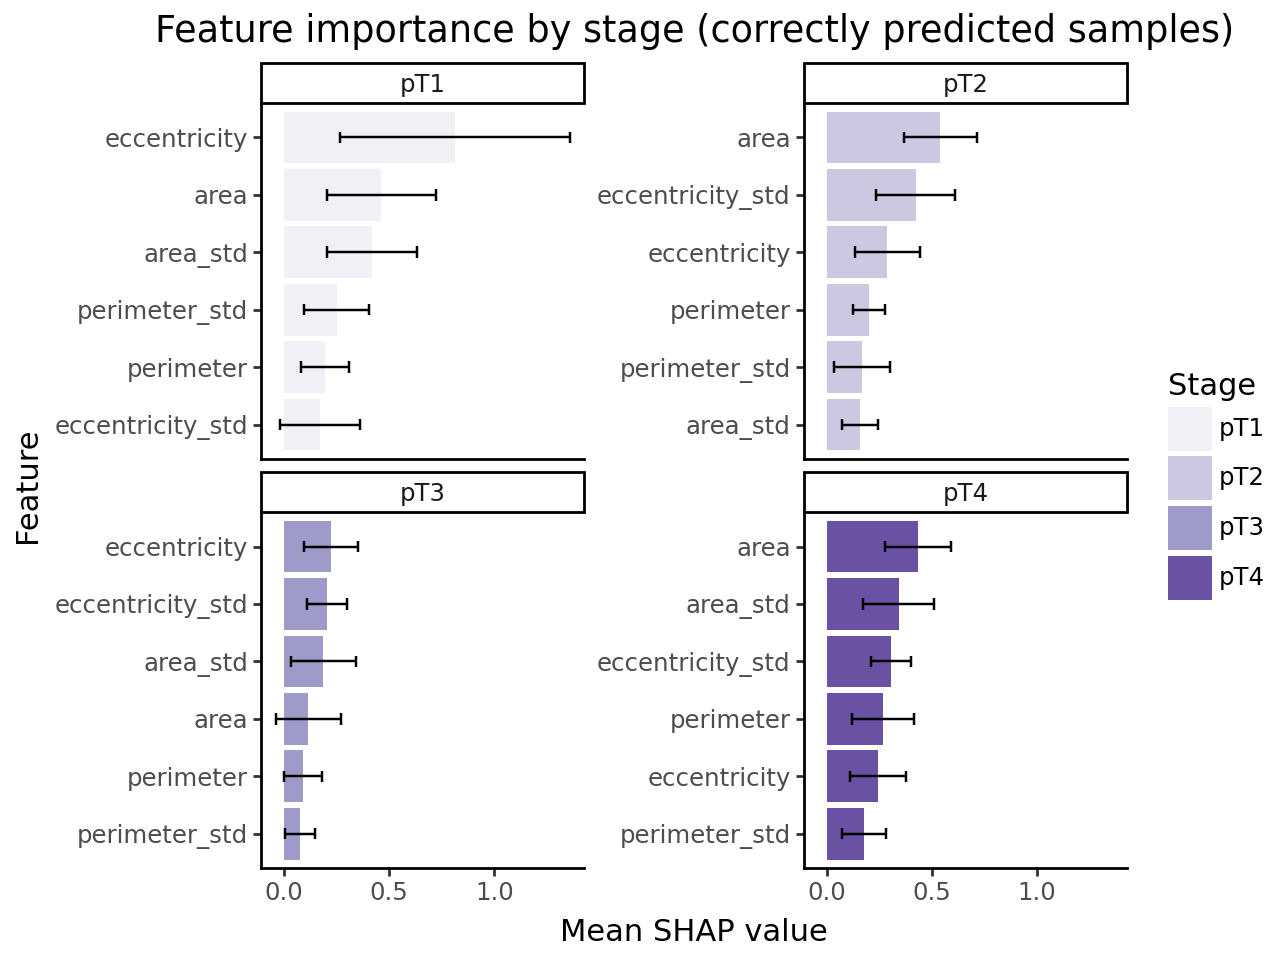

In [41]:
FT_PER_CLASS = 6 # Number of most important features kept per class

train_fov = df_morpho_per_fov.loc[meta_per_fov["inner"]]
original_stages = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(original_stages)

xgb = XGBClassifier(
    n_estimators=15, 
    max_depth=9, 
    device="cuda", 
    random_state=0)
xgb.fit(train_fov,
        true_labels)

explainer = shap.Explainer(xgb)
shap_values = explainer(train_fov)

# Purples + Green for healthy
pal_stages = [(242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

predicted_labels = xgb.predict(train_fov)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Few errors on training set, so not meaningful to interpret misclassified FOVs

# For each stage, see how the true positive samples were predicted (SHAP values)

# Get indices of correctly predicted samples for each class
correct_indices = {class_idx: np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0] 
                   for class_idx in range(conf_matrix.shape[0])}

shap_values_list = []
for class_idx, indices in correct_indices.items():
    shap_values_class = pd.DataFrame(shap_values.values[indices, :, class_idx], 
                                     columns=train_fov.columns)
    shap_values_class['fov'] = train_fov.index[indices]
    shap_values_class['class'] = label_encoder.inverse_transform([class_idx])[0]  # Use original stage names
    shap_values_list.append(shap_values_class)

shap_values_df = pd.concat(shap_values_list)

# Melt the DataFrame for easier plotting with plotnine
shap_values_melted = shap_values_df.melt(id_vars=['fov', 'class'], var_name='Feature', value_name='SHAP Value')

# Calculate mean and std SHAP values per feature per class
feature_importance = shap_values_melted.groupby(['class', 'Feature'])['SHAP Value'].agg(['mean', 'std']).reset_index()
feature_importance["abs_mean"] = np.abs(feature_importance["mean"])

# Create composite ordered categories per class
composite_data = []
categories_all = []
for class_name, group in feature_importance.groupby('class'):
    # Get top features for this class
    top_features = group.nlargest(FT_PER_CLASS, 'abs_mean').copy()
    # Sort by actual mean value (not absolute) for display order
    top_features = top_features.sort_values('mean', ascending=True)
    # Create composite category
    top_features['Class_Feature'] = top_features['class'] + ":" + top_features['Feature']
    categories_all.extend(top_features['Class_Feature'].tolist())
    composite_data.append(top_features)

# Combine data and assign global ordered categorical
feature_importance = pd.concat(composite_data)
feature_importance['Class_Feature'] = pd.Categorical(
    feature_importance['Class_Feature'],
    categories=categories_all,
    ordered=True
)

# Create plot
gp = (ggplot(feature_importance, 
        aes(x='Class_Feature', y='mean', fill='class'))
    + geom_bar(stat='identity')
    + geom_errorbar(aes(ymin='mean-0.5*std', ymax='mean+0.5*std'), 
                    width=0.2)
    + coord_flip()
    + theme_classic()
    + scale_fill_manual(values=pal_stages)
    + scale_x_discrete(labels=dict(zip(feature_importance['Class_Feature'], 
                                     feature_importance['Feature'])))
    + labs(title='Feature importance by stage (correctly predicted samples)', 
           x='Feature', y='Mean SHAP value', fill='Stage')
    + facet_wrap('~class', scales='free_y', ncol=2)
)

ggsave(gp, "../../figures/fig4/morpho_importance_correctly_predicted_samples.pdf", width=7, height=5)

gp.show()

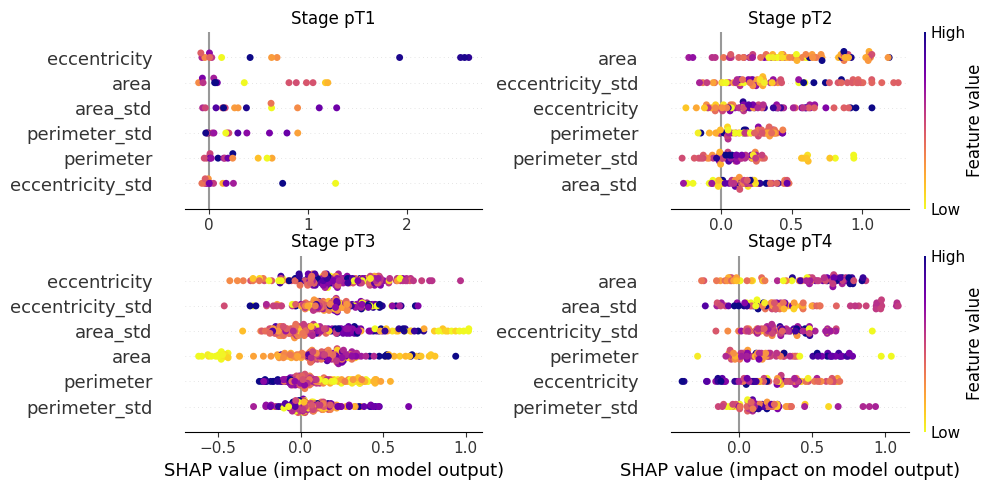

In [42]:
# Create a figure with 2x2 subplots with more space between them
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through classes and create SHAP beeswarm plot for each
for class_idx in range(shap_values.shape[2]):
    row = class_idx // 2
    col = class_idx % 2
    plt.sca(axes[row, col])
    
    # Get SHAP values for correctly predicted samples of this class
    class_shap = shap_values[np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0],:,class_idx]
    
    # Calculate average absolute SHAP values for ordering
    mean_abs_shap = np.abs(class_shap.values.mean(0))
    feature_order = np.argsort(-mean_abs_shap)  # Descending order
    
    # Create beeswarm plot with conditional show_colorbar
    shap.plots.beeswarm(
        class_shap, 
        show=False, 
        color=plt.get_cmap("plasma_r"),
        max_display=FT_PER_CLASS + 1,
        s = 25,
        order=feature_order,
        color_bar=col == 1  # Only show colorbar for right column
    )
    plt.title(f'Stage {label_encoder.inverse_transform([class_idx])[0]}')
    
    # Remove x-axis label for top row
    if row == 0:
        plt.xlabel('')

# Increase figure size and adjust margins
plt.gcf().set_size_inches(10, 5)
plt.tight_layout(w_pad=1.0, h_pad=0.0)  # Increase spacing between subplots

# Save complete figure
plt.savefig("../../figures/fig4/morpho_shap_vs_val_correctly_predicted_samples.pdf", 
            bbox_inches='tight')
plt.show()
plt.close()

In principle, we could as well look at the morphology of other cell types in the TME. However, this would require to make a lot of choices, as the FOVs with enough cells might not be the same, leading to non-trivial comparisons.

```Python
cells_per_fov = cell_table.groupby("fov").consensus.value_counts().unstack()
# Count NAs per type
cells_per_fov.isna().sum(axis="rows")
# We can also look at the morphology of CAF, NK_cell, CD4_Tcell, Monocyte,
# Endothelial_cell, Other_immune_cell

# morpho_features = ['eccentricity', 'perimeter', 'area']

# We now look at the cell shape of fibroblast cells
df_morpho = cell_table.loc[cell_table.consensus == "CAF",morpho_features] 

# Match meta dataframe
meta_morpho = cell_table.loc[cell_table.consensus == "CAF",["Stage","fov"]]
# Filter for well-annotated stages
meta_morpho = meta_morpho.loc[meta_morpho["Stage"].isin(["Colon-no.", "pT1", "pT2", "pT3", "pT4"])]
meta_morpho = meta_morpho.loc[~meta_morpho.fov.isin(
    meta_morpho.fov.value_counts()[meta_morpho.fov.value_counts() <= 3].index
    )]

df_morpho = df_morpho.loc[meta_morpho.index]
df_morpho["fov"] = meta_morpho["fov"]
# For mean only
# df_morpho_per_fov = df_morpho.groupby("fov").mean()
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")
meta_morpho_per_fov = meta_morpho.groupby("fov").first()

assert meta_morpho_per_fov.index.equals(df_morpho_per_fov.index)

# Note: if the predictions are not done on the same FOVs, comparison is not possible
# and the cross-validation splits cannot be re-used
```

## Model 5: MISTy cell type features
See *MistyLines.ipynb*.

In [43]:
misty_features_raw = pd.read_csv("../../data/misty_lineage_features.csv", index_col=0)
# Subset to top 100 most common features
misty_features = misty_features_raw.iloc[:,np.argsort(-np.sum(misty_features_raw > 0))[:100]]

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


In [44]:
# FOVs now exclude healthy samples
misty_features = misty_features.loc[meta_per_fov.index]

In [45]:
# Order is preserved
assert meta_per_fov.index.equals(misty_features.index)

In [46]:
def process_fold_misty(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define train and test subsets of the MISTy data
        train_misty = misty_features.loc[meta_per_fov["inner"]].iloc[train]
        test_misty = misty_features.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
        
        # Step 2: Train a classifier on the training data to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_misty,
                LabelEncoder().fit_transform(train_meta))
        
        # # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_misty)

        # # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="weighted")
        return score

In [47]:
def test_estimator_misty(estimators,depth):
    scores = [process_fold_misty(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model3_misty_lineage_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, mean_score)
    return mean_score

In [ ]:
# Parallelize the hyperparameter loop | ~ 30mn
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_misty)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

In [48]:
pd.read_csv("../../data/model3_misty_lineage_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
81,45,7,0.423738
80,35,7,0.416881
84,55,7,0.410673
77,25,7,0.410487
7,85,3,0.408264
75,15,7,0.407281
127,25,9,0.407259
8,95,3,0.404622
1,25,3,0.402953
85,65,7,0.402764


In [49]:
scores = [process_fold_misty(train, test, n_estimators=45, n_depth=7)
              for train, test in cv_folds_fov]
print(np.median(scores))

0.42373828018891724


In [50]:
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M5 spatial lineage" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

### CAF-Cancer trend

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 2.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/violin_caf_cancer_association.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_204878/2542368447.py:16: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


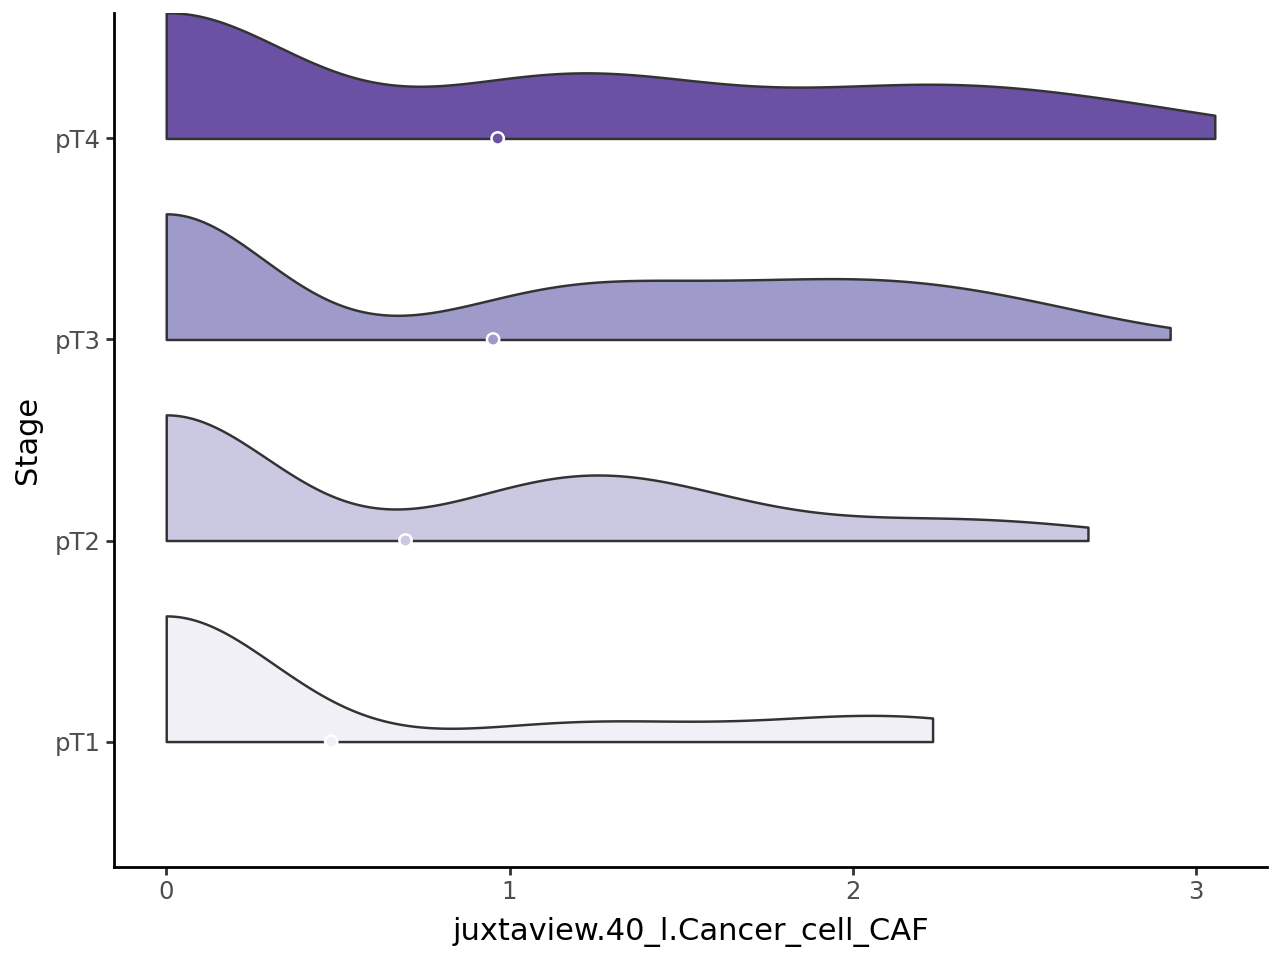

In [53]:
caf_df = misty_features.loc[:,['juxtaview.40_l.Cancer_cell_CAF']].join(meta_per_fov.Stage)

pal_stages = [(242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

gp = (ggplot(caf_df, aes(y='juxtaview.40_l.Cancer_cell_CAF', x='Stage', fill='Stage')) 
      + geom_violin(style="right", scale="width", width = 1.25) 
      + stat_summary(fun_y=np.mean, geom='point', color='white', size=2)
      + theme_classic() 
      + coord_flip()
      + scale_fill_manual(values = pal_stages)
      + theme(legend_position = "none"))

ggsave(gp, f"../../figures/fig4/violin_caf_cancer_association.pdf", width = 3, height = 2.5)
print(gp)

### SHAP analysis

[[ 14   0   0   0]
 [  0  68   0   0]
 [  0   0 174   0]
 [  0   0   0  78]]


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/misty_lineage_importance_correctly_predicted_samples.pdf


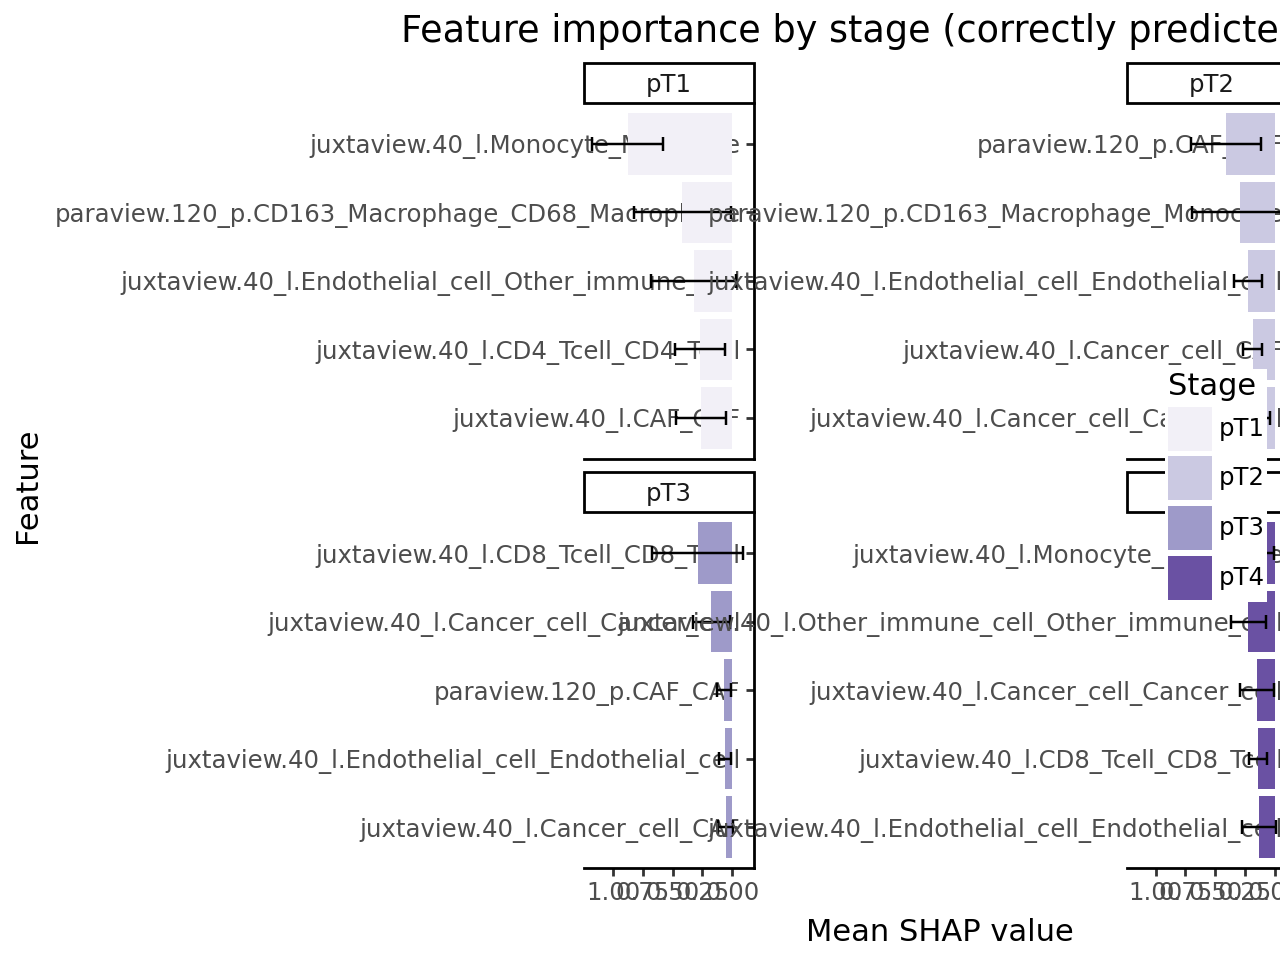

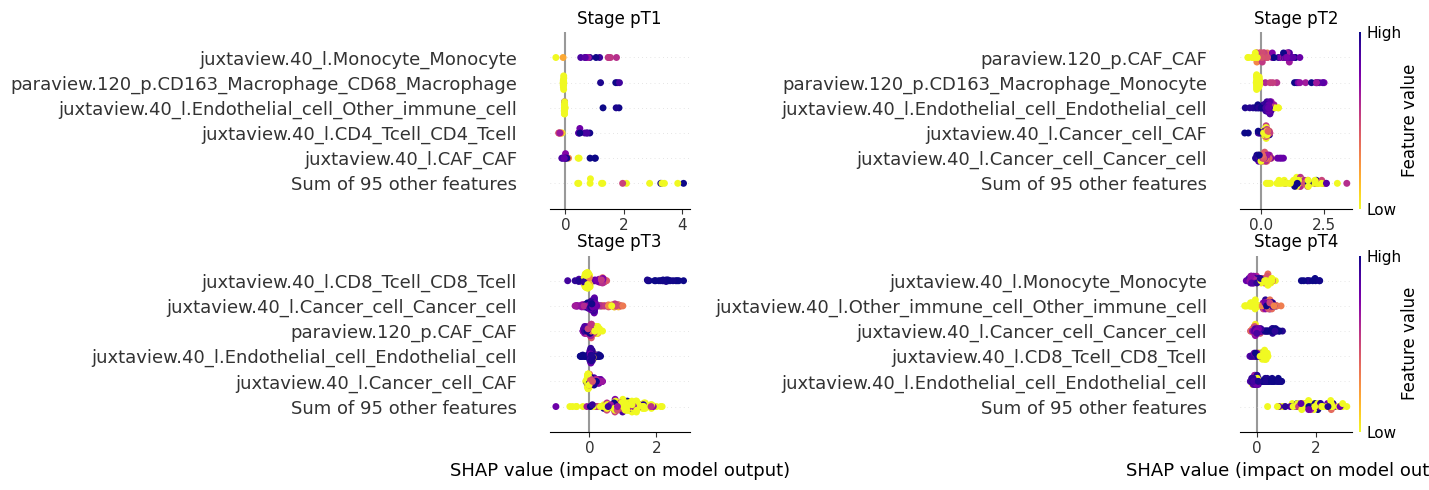

In [ ]:
FT_PER_CLASS = 5 # Number of most important features kept per class

train_misty = misty_features.loc[meta_per_fov["inner"]]
original_stages = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(original_stages)

xgb = XGBClassifier(
    n_estimators=45, 
    max_depth=7, 
    device="cuda", 
    random_state=0)
xgb.fit(train_misty,
        true_labels)

explainer = shap.Explainer(xgb)
shap_values = explainer(train_misty)

# Purples + Green for healthy
pal_stages = [(242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

predicted_labels = xgb.predict(train_misty)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Get indices of correctly predicted samples for each class
correct_indices = {class_idx: np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0] 
                   for class_idx in range(conf_matrix.shape[0])}

shap_values_list = []
for class_idx, indices in correct_indices.items():
    shap_values_class = pd.DataFrame(shap_values.values[indices, :, class_idx], 
                                     columns=train_misty.columns)
    shap_values_class['fov'] = train_misty.index[indices]
    shap_values_class['class'] = label_encoder.inverse_transform([class_idx])[0]  
    shap_values_list.append(shap_values_class)

shap_values_df = pd.concat(shap_values_list)

# Melt the DataFrame for easier plotting with plotnine
shap_values_melted = shap_values_df.melt(id_vars=['fov', 'class'], 
                                        var_name='Feature', 
                                        value_name='SHAP Value')

# Calculate mean and std SHAP values per feature per class
feature_importance = shap_values_melted.groupby(['class', 'Feature'])['SHAP Value'].agg(['mean', 'std']).reset_index()
feature_importance["abs_mean"] = np.abs(feature_importance["mean"])

# Create composite ordered categories per class
composite_data = []
categories_all = []
for class_name, group in feature_importance.groupby('class'):
    # Get top features for this class
    top_features = group.nlargest(FT_PER_CLASS, 'abs_mean').copy()
    # Sort by actual mean value (not absolute) for display order
    top_features = top_features.sort_values('mean', ascending=True)
    # Create composite category
    top_features['Class_Feature'] = top_features['class'] + ":" + top_features['Feature']
    categories_all.extend(top_features['Class_Feature'].tolist())
    composite_data.append(top_features)

# Combine data and assign global ordered categorical
feature_importance = pd.concat(composite_data)
feature_importance['Class_Feature'] = pd.Categorical(
    feature_importance['Class_Feature'],
    categories=categories_all,
    ordered=True
)

# Create bar plot
gp = (ggplot(feature_importance, 
        aes(x='Class_Feature', y='mean', fill='class'))
    + geom_bar(stat='identity')
    + geom_errorbar(aes(ymin='mean-0.5*std', ymax='mean+0.5*std'), 
                    width=0.2)
    + coord_flip()
    + theme_classic()
    + scale_fill_manual(values=pal_stages)
    + scale_x_discrete(labels=dict(zip(feature_importance['Class_Feature'], 
                                     feature_importance['Feature'])))
    + labs(title='Feature importance by stage (correctly predicted samples)', 
           x='Feature', y='Mean SHAP value', fill='Stage')
    + guides(fill 
    + facet_wrap('~class', scales='free_y', ncol=2)
)

ggsave(gp, "../../figures/fig4/misty_lineage_importance_correctly_predicted_samples.pdf", width=10, height=5)
gp.show()

# Create beeswarm plots
fig, axes = plt.subplots(2, 2, figsize=(14, 5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through classes and create SHAP beeswarm plot for each
for class_idx in range(shap_values.shape[2]):
    row = class_idx // 2
    col = class_idx % 2
    plt.sca(axes[row, col])
    
    # Get SHAP values for correctly predicted samples of this class
    class_shap = shap_values[np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0],:,class_idx]

    # Calculate average absolute SHAP values for ordering
    mean_abs_shap = np.abs(class_shap.values.mean(0))
    feature_order = np.argsort(-mean_abs_shap)  # Descending order
    
    # Create beeswarm plot with conditional show_colorbar
    shap.plots.beeswarm(
        class_shap, 
        show=False, 
        color=plt.get_cmap("plasma_r"),
        max_display=FT_PER_CLASS + 1,
        s = 25,
        order=feature_order,
        color_bar=col == 1  # Only show colorbar for right column
    )
    
    plt.title(f'Stage {label_encoder.inverse_transform([class_idx])[0]}')
    
    # Remove x-axis label for top row
    if row == 0:
        plt.xlabel('')

# Adjust figure size and margins
plt.gcf().set_size_inches(14, 5)
plt.tight_layout(w_pad=1.0, h_pad=0.0)

# Save complete figure
plt.savefig("../../figures/fig4/misty_lineage_shap_vs_val_correctly_predicted_samples.pdf", 
            bbox_inches='tight')
plt.show()
plt.close()

## Model 6: Kasumi metabolic features
See *KasumiColorectal.ipynb*. We note that training on the FOV-level associations rather than the cluster frequencies lead to better performance.

In [52]:
misty_features_raw = pd.read_csv("../../data/kasumi_metab_features.csv", index_col=0)
# Subset to top 100 most common features
misty_features = misty_features_raw.iloc[:,np.argsort(-np.sum(misty_features_raw > 0))[:100]]

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


In [53]:
# FOVs now exclude healthy samples
misty_features = misty_features.loc[meta_per_fov.index]

In [54]:
# Order is preserved
assert meta_per_fov.index.equals(misty_features.index)

In [55]:
def process_fold_misty(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define train and test subsets of the MISTy data
        train_misty = misty_features.loc[meta_per_fov["inner"]].iloc[train]
        test_misty = misty_features.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
        
        # Step 2: Train a classifier on the training data to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_misty,
                LabelEncoder().fit_transform(train_meta))
        
        # # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_misty)

        # # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="weighted")
        return score

In [56]:
def test_estimator_misty(estimators,depth):
    scores = [process_fold_misty(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model7_kasumi_marker_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, mean_score)
    return mean_score

In [ ]:
# Parallelize the hyperparameter loop | ~ 30mn
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_misty)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

In [57]:
pd.read_csv("../../data/model7_kasumi_marker_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
146,115,9,0.427298
148,125,9,0.423394
150,135,9,0.423394
154,155,9,0.423394
152,145,9,0.423394
157,165,9,0.423394
192,435,9,0.423174
193,445,9,0.423174
195,465,9,0.423174
198,495,9,0.423174


In [58]:
scores = [process_fold_misty(train, test, n_estimators=115, n_depth=9)
              for train, test in cv_folds_fov]
print(np.median(scores))

0.4272981448609179


In [59]:
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M6 spatial metabolism" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

## Summary of models selection

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 11.2 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/inner_f1_scores.pdf


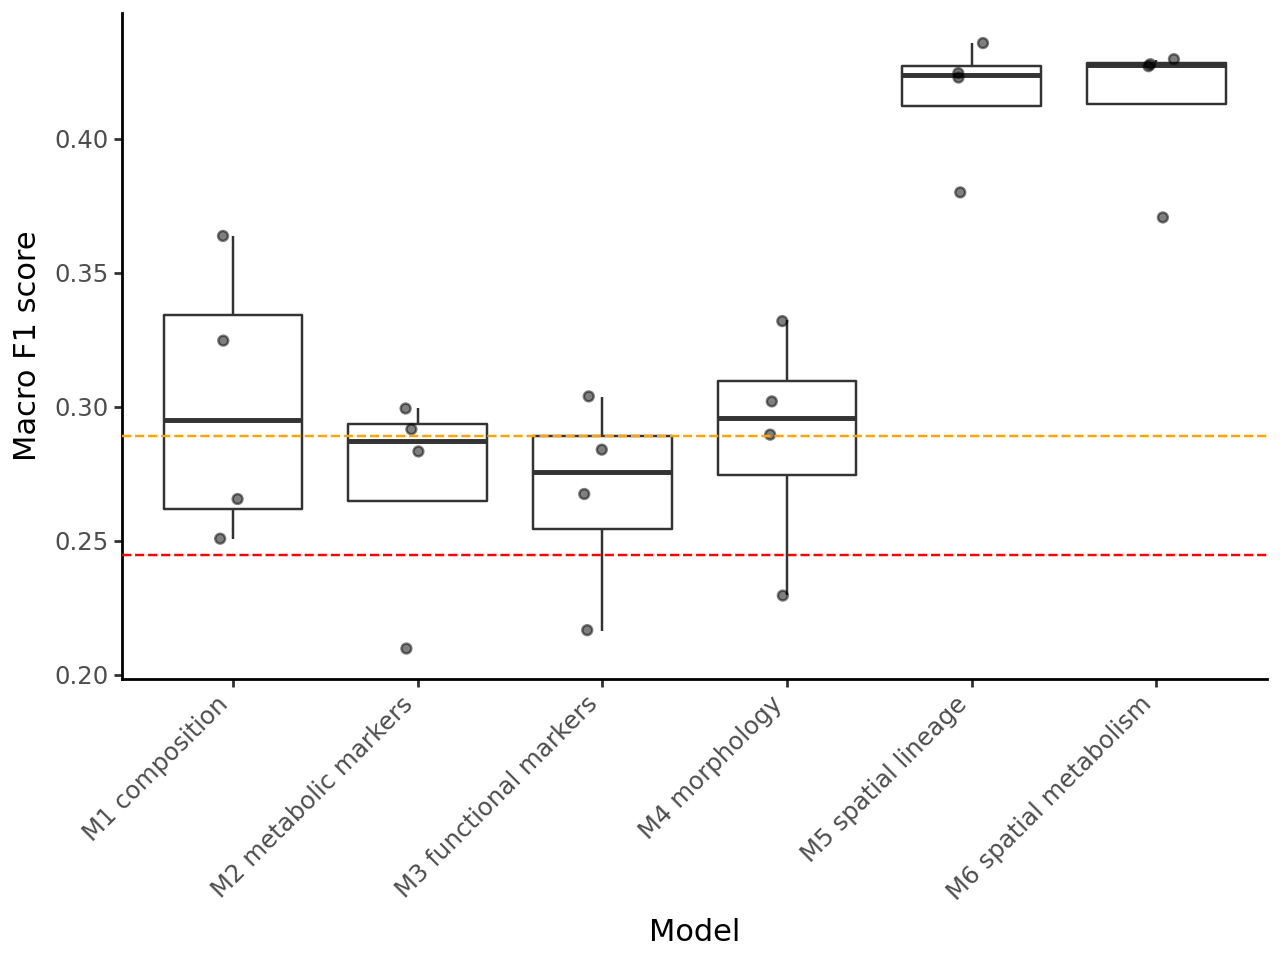

In [60]:
gp = (ggplot(all_models_inner, aes(x = "model", y = "score")) 
      + geom_boxplot(outlier_alpha = 0) 
      + geom_jitter(width = 0.1, alpha = 0.5)
      + theme_classic()
      + geom_hline(yintercept=np.median(np.median(all_f1_scores, axis = 0)), linetype="dashed", color="red")
      + geom_hline(yintercept=np.quantile(np.median(all_f1_scores, axis = 0), 0.95), linetype="dashed", color="orange")      
      + theme(axis_text_x = element_text(angle = 45, hjust = 1))
      + labs(x = "Model", y = "Macro F1 score")
)
ggsave(gp, "../../figures/fig4/inner_f1_scores.pdf", width=11.2, height=5)
gp.show()